In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os
from mpldatacursor import datacursor  
import math  
import sys  
sys.path.append('C:/Users/j/hotai/myfolder')

from my_function import miscore, siscore
# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

addp=5
startp=80
endp=120
dp=endp-startp
p_tot=addp*(dp-1)+1
file_tot=100
n=25
xstart=0
xend=25

In [2]:
def read_data(file_path,file_name,n,file_start=0,file_end=0,xstart=0,xend=0):
    x=np.zeros((121,n,n))
    y=np.zeros((121,n,n))
    vx=np.zeros((121,n,n))
    vy=np.zeros((121,n,n))
    for i in range(file_start,file_end):
        xp=[]
        yp=[]
        vxp=[]
        vyp=[]
        isvalid=[]
        xtmp=[]
        ytmp=[]
        vxtmp=[]
        vytmp=[]
        isvalidtmp=[]
        
        for root,dirs,files in os.walk(file_path):
            #print(root)
            
            for dir in dirs:
                #print(os.path.join(root,file))
                
    
                    with open(os.path.join(root,dir,file_name[i]), 'r') as f:  
                        lines = f.readlines()
                        for line in lines[3:]: 
                            num=line.split()
                            xtmp.append(float(num[0]))
                            ytmp.append(float(num[1]))
                            vxtmp.append(float(num[2]))
                            vytmp.append(float(num[3]))
                            isvalidtmp.append(float(num[4]))
        
                    xp.append(np.array(xtmp).reshape(25,25))
                    yp.append(np.array(ytmp).reshape(25,25))
                    vxp.append(np.array(vxtmp).reshape(25,25))
                    vyp.append(np.array(vytmp).reshape(25,25))
                    isvalid.append(np.array(isvalidtmp).reshape(25,25))
                    xtmp=[]
                    ytmp=[]
                    vxtmp=[]
                    vytmp=[]
                    isvalidtmp=[]
        #
        xp=np.array(xp)
        yp=np.array(yp)
        vxp=np.array(vxp)
        vyp=np.array(vyp)
        isvalid=np.array(isvalid)
        x=x+xp/file_tot
        y=y+yp/file_tot
        vx=vx+vxp/file_tot
        vy=vy+vyp/file_tot
    x=x.T
    x=x[xstart:xend,xstart:xend]
    y=y.T
    y=y[xstart:xend,xstart:xend]
    vx=vx.T
    vx=vx[xstart:xend,xstart:xend]
    vy=vy.T
    vy=vy[xstart:xend,xstart:xend]
    isvalid=isvalid.T
    isvalid=isvalid[xstart:xend,xstart:xend]
    return x,y,vx,vy

In [3]:
file_path = os.path.join('D:\\', 'hotaidata','sr_C6_01')
file_name=['B00001.dat','B00002.dat','B00003.dat','B00004.dat','B00005.dat','B00006.dat','B00007.dat','B00008.dat',
           'B00009.dat','B00010.dat','B00011.dat','B00012.dat','B00013.dat','B00014.dat','B00015.dat','B00016.dat','B00017.dat',
           'B00018.dat','B00019.dat','B00020.dat','B00021.dat','B00022.dat','B00023.dat','B00024.dat','B00025.dat','B00026.dat',
           'B00027.dat','B00028.dat','B00029.dat','B00030.dat','B00031.dat','B00032.dat','B00033.dat','B00034.dat','B00035.dat',
           'B00036.dat','B00037.dat','B00038.dat','B00039.dat','B00040.dat','B00041.dat','B00042.dat','B00043.dat','B00044.dat',
           'B00045.dat','B00046.dat','B00047.dat','B00048.dat','B00049.dat','B00050.dat','B00051.dat','B00052.dat','B00053.dat',
           'B00054.dat','B00055.dat','B00056.dat','B00057.dat','B00058.dat','B00059.dat','B00060.dat','B00061.dat','B00062.dat',
           'B00063.dat','B00064.dat','B00065.dat','B00066.dat','B00067.dat','B00068.dat','B00069.dat','B00070.dat','B00071.dat',
           'B00072.dat','B00073.dat','B00074.dat','B00075.dat','B00076.dat','B00077.dat','B00078.dat','B00079.dat','B00080.dat',
           'B00081.dat','B00082.dat','B00083.dat','B00084.dat','B00085.dat','B00086.dat','B00087.dat','B00088.dat','B00089.dat',
           'B00090.dat','B00091.dat','B00092.dat','B00093.dat','B00094.dat','B00095.dat','B00096.dat','B00097.dat','B00098.dat',
           'B00099.dat','B00100.dat']
x=np.zeros((121,n,n))
y=np.zeros((121,n,n))
vx=np.zeros((121,n,n))
vy=np.zeros((121,n,n))

x,y,vx,vy=read_data(file_path,file_name,25,0,50,xstart,xend)
#print(x[0,:,:])
t=np.linspace(0,60/800,121)
dt=t[1]-t[0]

t=t[startp:endp]
print(len(t))
t_train=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_train=t_train[1]-t_train[0]
print(len(t_train.shape))

40
1


In [4]:
#u is not pre adding, v add a median
spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=xend-xstart

t_in=np.zeros((n,n,dp))
for i in range (dp):
    t_in[:,:,i]=t[i]

print(t_in[0,0])

u=np.zeros((n,n,121, 3))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u[:, :, startp:endp, 2] = t_in
u_train=np.zeros((n,n,len(t), 3))
u_train=u[:,:,startp:endp,:]

v_train=np.zeros((n,n,len(t_train),3))

for i in range(len(t)-1):
    for j in range(addp):
        v_train[:,:,addp*i+j]=(u_train[:,:,i]*(addp-j)+u_train[:,:,i+1]*j)/addp
v_train[:,:,-1]=u_train[:,:,-1]


[0.05     0.050625 0.05125  0.051875 0.0525   0.053125 0.05375  0.054375
 0.055    0.055625 0.05625  0.056875 0.0575   0.058125 0.05875  0.059375
 0.06     0.060625 0.06125  0.061875 0.0625   0.063125 0.06375  0.064375
 0.065    0.065625 0.06625  0.066875 0.0675   0.068125 0.06875  0.069375
 0.07     0.070625 0.07125  0.071875 0.0725   0.073125 0.07375  0.074375]


<function matplotlib.pyplot.show(close=None, block=None)>

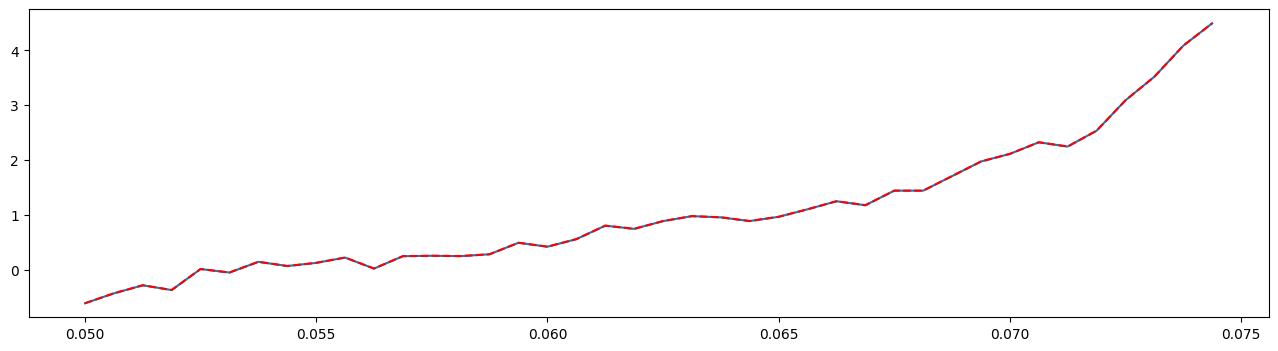

In [5]:
op=np.zeros(len(t))
op=u_train[10,10,:,0]
op_train=np.zeros(len(t_train))
for i in range(len(t)-1):
    for j in range(addp):
        op_train[i*addp+j]=(op[i]*(addp-j)+op[i+1]*j)/addp
op_train[-1]=op[-1]
plt.figure(figsize=(16, 4))
plt.plot(t,op)
plt.plot(t_train,op_train,'r--')
plt.show

In [6]:
v_train_dot = ps.FiniteDifference(axis=2)._differentiate(v_train, dt_train)

vtmp=np.zeros(v_train_dot.shape)
vtmp[:,:,0]=v_train[:,:,0]
for i in range(len(t_train)-1):
    vtmp[:,:,i+1]=vtmp[:,:,i]+v_train_dot[:,:,i]*dt_train
miscore(vtmp,v_train)
siscore(vtmp,v_train)
vtmp=v_train+v_train_dot*dt_train

vtmp[:,:,1:]=vtmp[:,:,:len(t_train)-1]
miscore(vtmp,v_train)
siscore(vtmp,v_train)


MI(average/percent):
0.9956925134901965 0.9998189598420013
SI(average/percent):
0.9999999999999895 1.0
MI(average/percent):
0.9991808505943115 0.9999835418038183
SI(average/percent):
0.999941979793968 1.0


(0.999941979793968, 1.0)

In [7]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.    periodic=True

library_functions = [
    lambda y: y,
    lambda x: x * x,
    
    lambda x, y: x * y,
    lambda x, y: x * x * y,
    lambda x, y, z: x * y * z
]
library_function_names = [
    lambda y: y,
    lambda x: x + x,
    
    lambda x, y: x + y,
    lambda x, y: x + x + y,
    lambda x, y, z: x + y + z
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True
    
)



'''
print('SINDy')
model = ps.SINDy(feature_library=pde_lib, feature_names=['Vx','Vy','t'])

model.fit(v_train, x_dot=v_train_dot)
model.print()
#u_dot_stlsq = model.predict(v_train)x_dot=v_train_dot
'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy','t'])
model.fit(v_train, dt_train)
model.print()

STLSQ model: 
(Vx)' = 2749.684 1 + 36.456 Vx + 45.061 Vy + -92222.667 t + -43.138 VxVx + -23.285 VyVy + 771638.320 tt + -0.291 VxVy + -300.630 Vxt + -336.634 Vyt + -0.748 VxVxVy + 720.898 VxVxt + 490.316 VyVyt + -119.300 VxVyt + 3524.939 Vx_2 + -2237.660 Vy_2 + -1380.129 Vx_1 + -1544.988 Vy_1 + -198.081 VxVx_2 + 397.778 VxVy_2 + -117663.421 Vxt_2 + 0.608 VyVx_2 + -73.673 VyVy_2 + 983971.213 Vyt_2 + 32.255 tVx_2 + 2905.745 tVy_2 + -7802.068 tt_2 + 1.242 VxVxVx_2 + -103.914 VxVxVy_2 + 1095.843 VxVxt_2 + -355.243 VyVyVx_2 + -439.466 VyVyVy_2 + -145.773 VyVyt_2 + 80676.107 ttVx_2 + 61.960 ttVy_2 + 12.123 ttt_2 + -715539.147 VxVyVx_2 + 92.411 VxVyVy_2 + 8225.146 VxVyt_2 + 2441.575 VxtVx_2 + -1.201 VxtVy_2 + -1045.726 Vxtt_2 + -196.897 VytVx_2 + -1289.687 VytVy_2 + -74.001 VxVx_1 + -455.636 VxVy_1 + 50660.351 Vxt_1 + 46.761 VyVx_1 + 37.724 VyVy_1 + -456213.994 Vyt_1 + -33.058 tVx_1 + 1114.565 tVy_1 + 5675.625 tt_1 + 0.790 VxVxVx_1 + -729.378 VxVxVy_1 + -363.881 VxVxt_1 + 649.850 VyVyVx_1 + 1

In [8]:
print("Model score: %f" % model.score(u_train, t=t))
print("Model score: %f" % model.score(u_train, t=dt))
print("Model score: %f" % model.score(v_train, t=t_train))
print("Model score: %f" % model.score(v_train, t=dt_train))

Model score: -10.341921
Model score: -22.386048
Model score: 0.231278
Model score: 0.316690


In [9]:
x_test,y_test,vx_test,vy_test=read_data(file_path,file_name,25,50,100,xstart,xend)


t_test=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_test=t_test[1]-t_test[0]

si_t=np.zeros(p_tot)
mi_t=np.zeros(p_tot)
si_t_per=np.zeros(p_tot)
mi_t_per=np.zeros(p_tot)

In [10]:
#u is not pre adding, v add a median


n=xend-xstart


u[:, :, :, 0] = vx_test
u[:, :, :, 1] = vy_test

u_test=np.zeros((n,n,len(t), 3))
u_test=u[:,:,startp:endp,:]

v_test=np.zeros((n,n,len(t_test),3))
for i in range(len(t)-1):
    for j in range(addp):
        v_test[:,:,addp*i+j]=(u_test[:,:,i]*(addp-j)+u_test[:,:,i+1]*j)/addp
v_test[:,:,-1]=u_test[:,:,-1]


In [11]:
x_dot_test_predicted = model.predict(v_test)
x_dot_test_predicted=x_dot_test_predicted.reshape(n,n,p_tot,3)
tlen=len(t_train)
dot_tmp=np.array(x_dot_test_predicted)
pltpredict=np.zeros((n,n,tlen,2))
#print(dot_tmp[10,10])

In [12]:
print('add 7 point, from 80 to 120, with library x^3, derivative order 2, MI:0.6748241001379309, SI:0.8570345301079201')
print('add 7 point, from 80 to 120, with library x^3, derivative order 1, MI:0.6732771082529756, SI:0.8589308511150588')
print('add 7 point, from 80 to 120, with library x^2, derivative order 2, MI:0.6707939885275049, SI:0.8459658232811543')
print('add 7 point, from 80 to 120, with library x^2, derivative order 1, MI:0.6693806511354194, SI:0.8426666431380524')
print('add 7 point, from 90 to 120, with library x^2, derivative order 1, MI:0.6709005447980256, SI:0.8424080789942714')

pltpredict[:,:,0]=v_train[:,:,0,:2]
for i in range(tlen-1):
    pltpredict[:,:,i+1]=pltpredict[:,:,i]+dot_tmp[:,:,i,:2]*dt_train
miscore(pltpredict,v_test)
siscore(pltpredict,v_test)
#print(pltpredict[10,10])
#print(v_train[10,10])

add 7 point, from 80 to 120, with library x^3, derivative order 2, MI:0.6748241001379309, SI:0.8570345301079201
add 7 point, from 80 to 120, with library x^3, derivative order 1, MI:0.6732771082529756, SI:0.8589308511150588
add 7 point, from 80 to 120, with library x^2, derivative order 2, MI:0.6707939885275049, SI:0.8459658232811543
add 7 point, from 80 to 120, with library x^2, derivative order 1, MI:0.6693806511354194, SI:0.8426666431380524
add 7 point, from 90 to 120, with library x^2, derivative order 1, MI:0.6709005447980256, SI:0.8424080789942714
MI(average/percent):
0.8915462964505028 0.8520243581303489
SI(average/percent):
0.9903985408088273 0.9935483870967742


(0.9903985408088273, 0.9935483870967742)

0


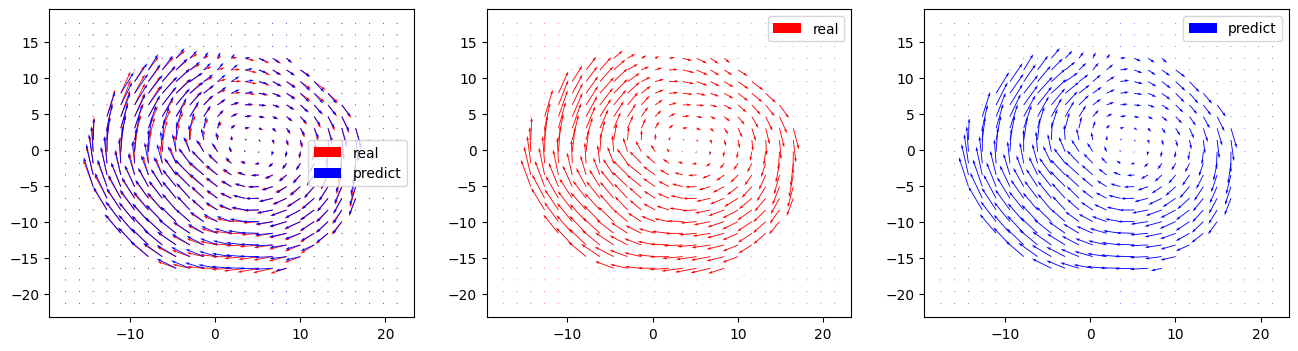

MI(average/percent):
0.9607816972397859 0.9903225806451613
SI(average/percent):
0.989808635900033 0.9935483870967742
1
MI(average/percent):
0.9610027284093057 0.9903225806451613
SI(average/percent):
0.9909884457176192 0.9935483870967742
2
MI(average/percent):
0.9603322806458628 0.9903225806451613
SI(average/percent):
0.9918479755104936 0.9967741935483871
3
MI(average/percent):
0.9586703981110754 0.9903225806451613
SI(average/percent):
0.9924161386961734 0.9967741935483871
4
MI(average/percent):
0.9562274533286018 0.9806451612903225
SI(average/percent):
0.9927180297217147 0.9967741935483871
5


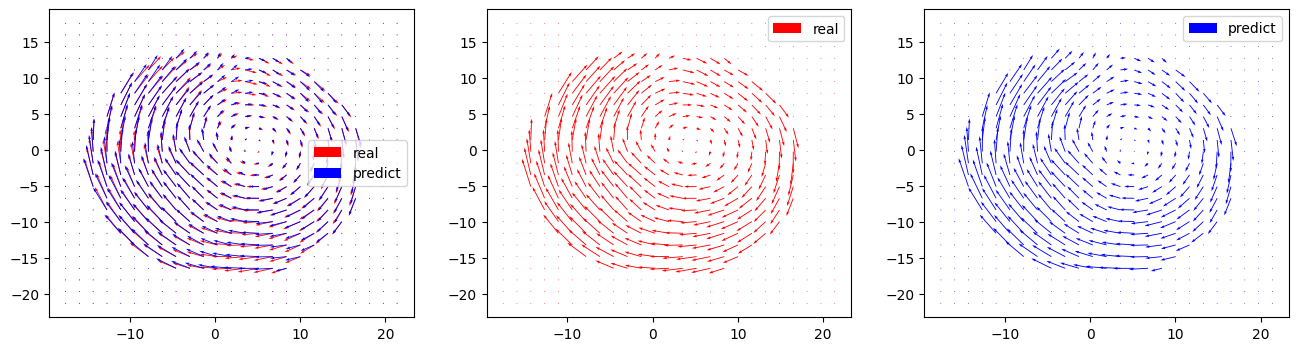

MI(average/percent):
0.9529953961138983 0.9806451612903225
SI(average/percent):
0.9927751457978437 0.9967741935483871
6
MI(average/percent):
0.9523058703709726 0.9838709677419355
SI(average/percent):
0.9927707477433032 0.9967741935483871
7
MI(average/percent):
0.9512005521910075 0.9806451612903225
SI(average/percent):
0.9926471336697975 0.9967741935483871
8
MI(average/percent):
0.9499860559321925 0.9741935483870968
SI(average/percent):
0.9923980730913132 1.0
9
MI(average/percent):
0.9486037748958401 0.9741935483870968
SI(average/percent):
0.9920158204373609 1.0
10


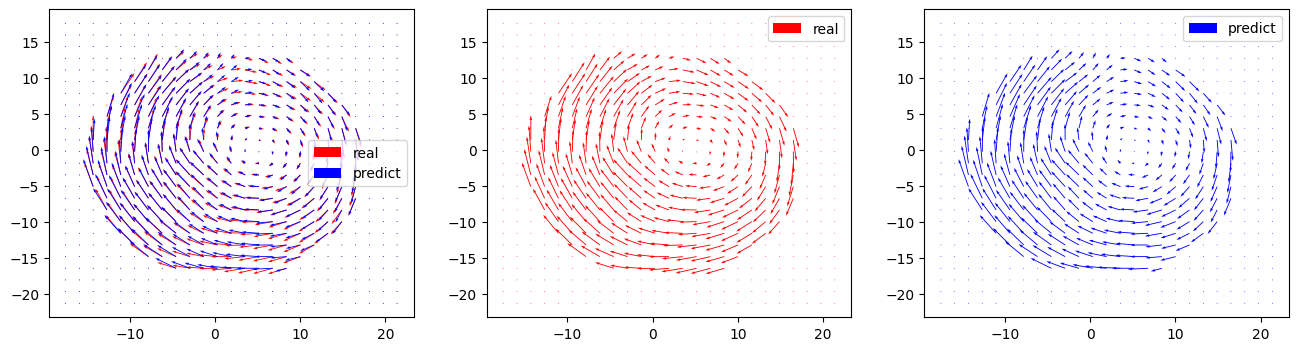

MI(average/percent):
0.9468255349373619 0.9774193548387097
SI(average/percent):
0.9914898869953012 1.0
11
MI(average/percent):
0.9460395617783942 0.9741935483870968
SI(average/percent):
0.9916284119389327 1.0
12
MI(average/percent):
0.9450602045587394 0.9709677419354839
SI(average/percent):
0.9915109487930996 1.0
13
MI(average/percent):
0.9439488322926554 0.9741935483870968
SI(average/percent):
0.9908471478563843 0.9967741935483871
14
MI(average/percent):
0.9425855886167721 0.9741935483870968
SI(average/percent):
0.9888006590554885 0.9935483870967742
15


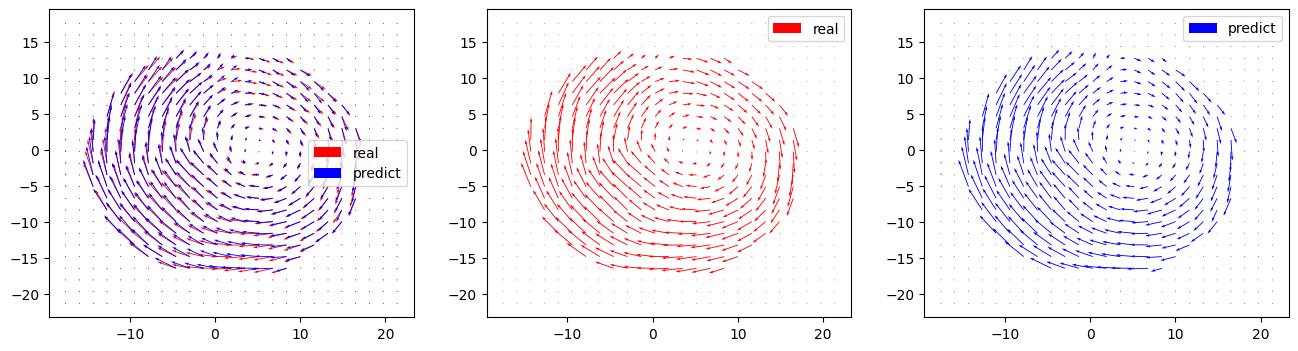

MI(average/percent):
0.9412013448272888 0.9709677419354839
SI(average/percent):
0.9898878181917893 0.9935483870967742
16
MI(average/percent):
0.9431975767075214 0.9741935483870968
SI(average/percent):
0.9910214578446527 1.0
17
MI(average/percent):
0.944646895806785 0.9741935483870968
SI(average/percent):
0.9912906129044379 1.0
18
MI(average/percent):
0.9459038305731096 0.9774193548387097
SI(average/percent):
0.9911028199461348 1.0
19
MI(average/percent):
0.946693561989697 0.9838709677419355
SI(average/percent):
0.9905492335308583 1.0
20


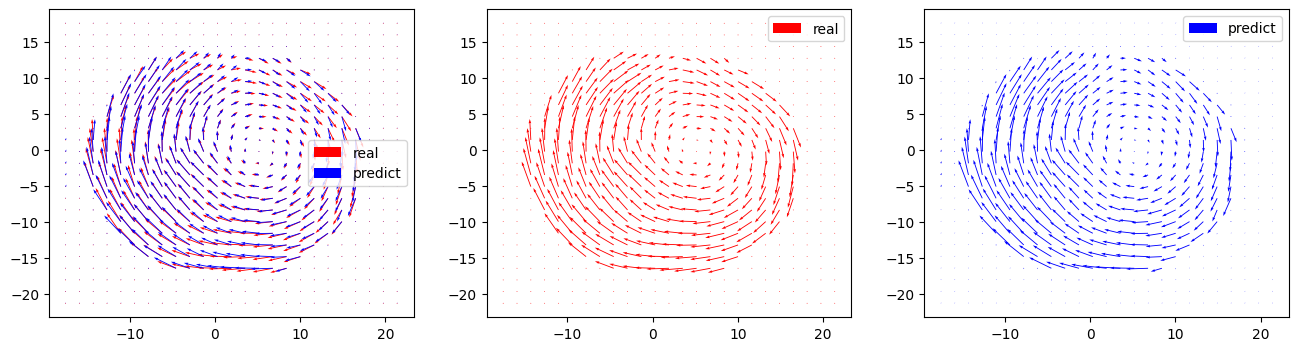

MI(average/percent):
0.9468378025369463 0.9870967741935484
SI(average/percent):
0.9896293104782338 1.0
21
MI(average/percent):
0.946726149776649 0.9774193548387097
SI(average/percent):
0.9897309538836883 1.0
22
MI(average/percent):
0.9462667884445722 0.9741935483870968
SI(average/percent):
0.9896578867570442 1.0
23
MI(average/percent):
0.9455680383132159 0.967741935483871
SI(average/percent):
0.9894150510335031 0.9967741935483871
24
MI(average/percent):
0.9444439299677977 0.964516129032258
SI(average/percent):
0.9890044011402426 0.9967741935483871
25


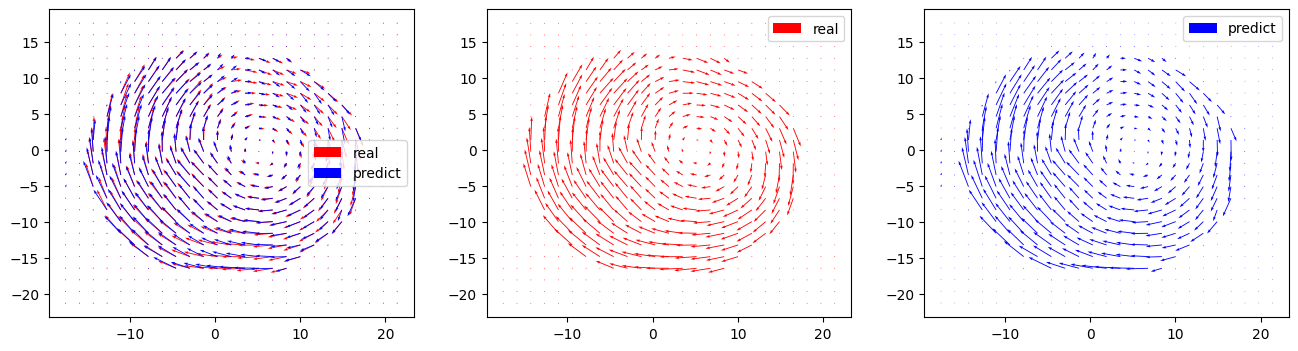

MI(average/percent):
0.9428754757681997 0.964516129032258
SI(average/percent):
0.9884252235339067 0.9967741935483871
26
MI(average/percent):
0.9438701598538133 0.967741935483871
SI(average/percent):
0.9880577659442037 0.9967741935483871
27
MI(average/percent):
0.9439572672867149 0.967741935483871
SI(average/percent):
0.9873007711359855 0.9967741935483871
28
MI(average/percent):
0.9432071585676223 0.9709677419354839
SI(average/percent):
0.9859295963025861 0.9967741935483871
29
MI(average/percent):
0.9423283221663697 0.9709677419354839
SI(average/percent):
0.9861070043319833 0.9967741935483871
30


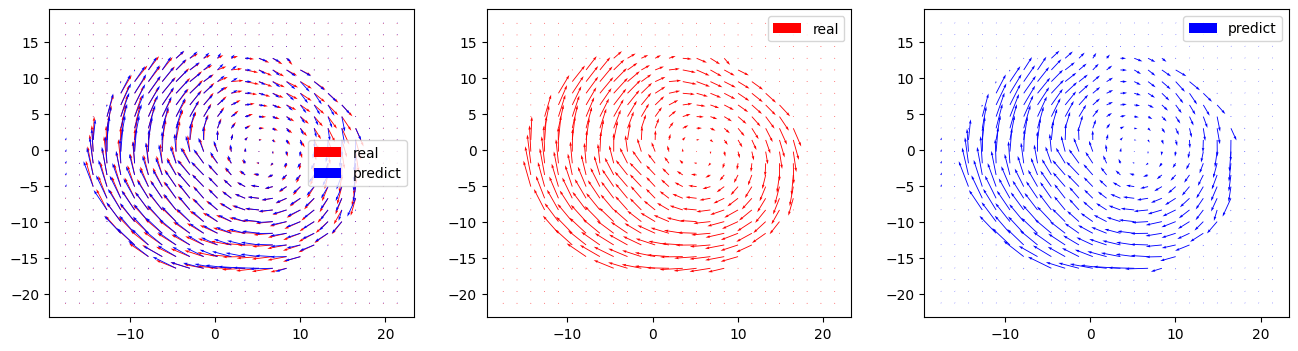

MI(average/percent):
0.9415284175073805 0.9774193548387097
SI(average/percent):
0.9866232449996409 0.9967741935483871
31
MI(average/percent):
0.9413322664402046 0.9774193548387097
SI(average/percent):
0.9858642417191473 0.9967741935483871
32
MI(average/percent):
0.9408535369730724 0.9774193548387097
SI(average/percent):
0.9840775490477903 0.9967741935483871
33
MI(average/percent):
0.9402594033627375 0.9774193548387097
SI(average/percent):
0.9851163679817343 0.9967741935483871
34
MI(average/percent):
0.9398015802665733 0.9709677419354839
SI(average/percent):
0.9855529256953567 1.0
35


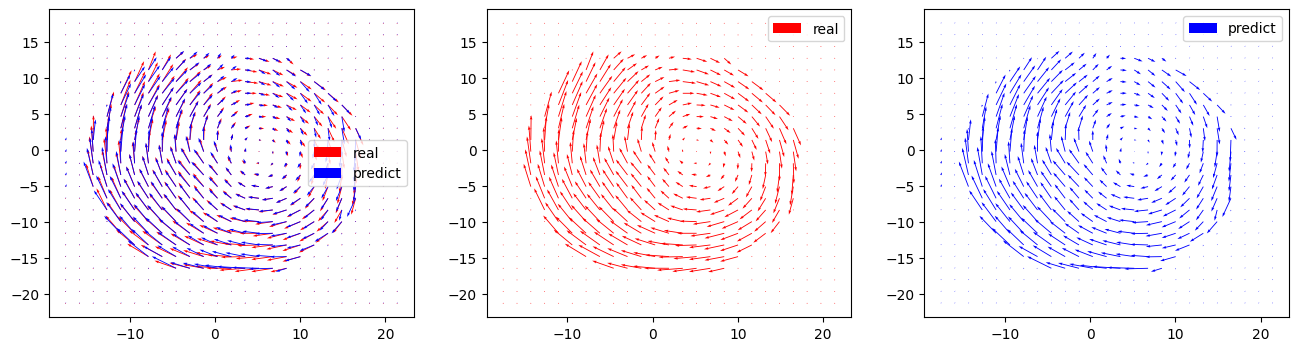

MI(average/percent):
0.9389752980692616 0.9709677419354839
SI(average/percent):
0.9851031067483254 1.0
36
MI(average/percent):
0.9399098587834912 0.9612903225806452
SI(average/percent):
0.9845675856310461 1.0
37
MI(average/percent):
0.9405628319281883 0.9580645161290322
SI(average/percent):
0.9835767784180962 0.9967741935483871
38
MI(average/percent):
0.9408922814567936 0.9451612903225807
SI(average/percent):
0.9821789421837698 0.9967741935483871
39
MI(average/percent):
0.940516596750499 0.9419354838709677
SI(average/percent):
0.980588425873809 0.9967741935483871
40


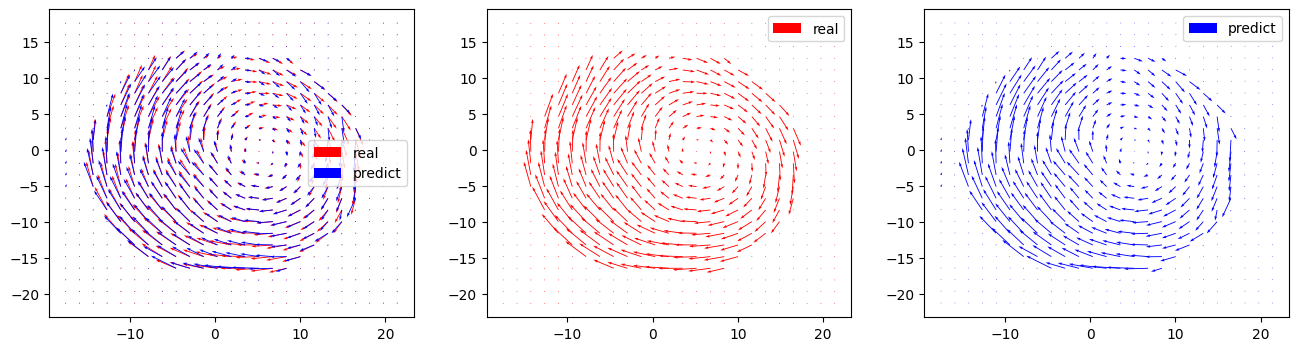

MI(average/percent):
0.939695892582061 0.9387096774193548
SI(average/percent):
0.9789714546853541 0.9967741935483871
41
MI(average/percent):
0.939936400889925 0.9451612903225807
SI(average/percent):
0.9780596980913563 0.9967741935483871
42
MI(average/percent):
0.9393398912181655 0.9451612903225807
SI(average/percent):
0.9779848958306556 0.9967741935483871
43
MI(average/percent):
0.9383311658474154 0.9419354838709677
SI(average/percent):
0.9790251892659343 1.0
44
MI(average/percent):
0.9375800811045335 0.9419354838709677
SI(average/percent):
0.9764755594144732 0.9967741935483871
45


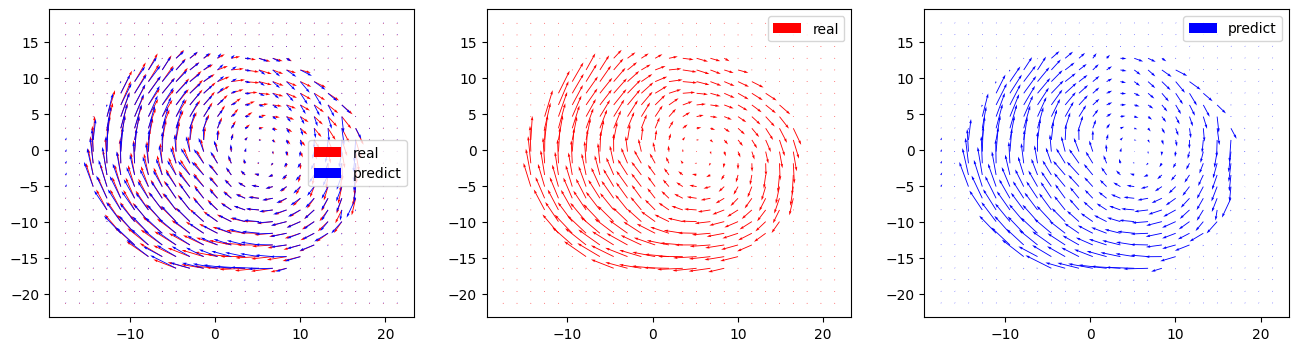

MI(average/percent):
0.9361233857140929 0.9387096774193548
SI(average/percent):
0.974658929570798 0.9967741935483871
46
MI(average/percent):
0.9362365165064892 0.9419354838709677
SI(average/percent):
0.9748719800492086 1.0
47
MI(average/percent):
0.9362900136372997 0.9419354838709677
SI(average/percent):
0.9742813701977121 1.0
48
MI(average/percent):
0.9360058308646966 0.9451612903225807
SI(average/percent):
0.9730354609831139 0.9935483870967742
49
MI(average/percent):
0.935318573574018 0.9483870967741935
SI(average/percent):
0.9714549986490715 0.9838709677419355
50


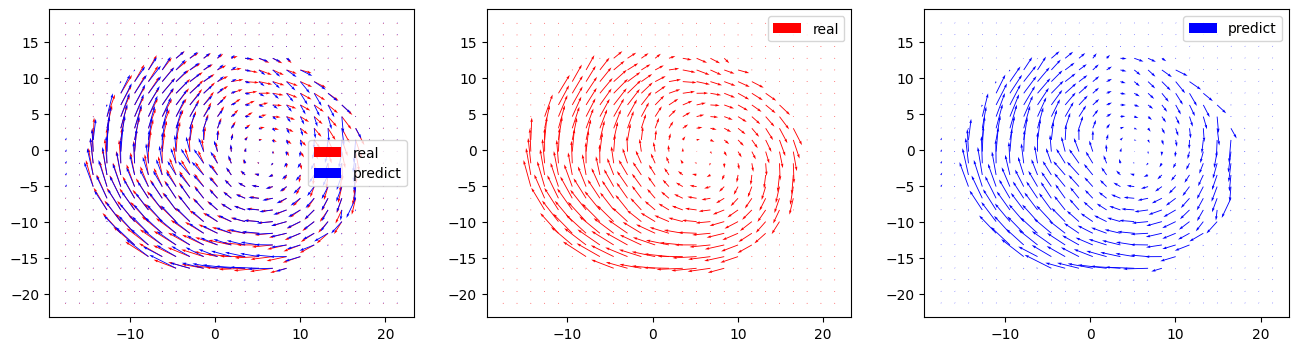

MI(average/percent):
0.9341620667064983 0.9451612903225807
SI(average/percent):
0.9696723913933623 0.9774193548387097
51
MI(average/percent):
0.9347179082280072 0.9451612903225807
SI(average/percent):
0.9695653544504097 0.9774193548387097
52
MI(average/percent):
0.9348262197842359 0.9483870967741935
SI(average/percent):
0.9693154567870703 0.9870967741935484
53
MI(average/percent):
0.9345447837670053 0.9483870967741935
SI(average/percent):
0.9689224423287891 0.9774193548387097
54
MI(average/percent):
0.9338041977472743 0.9483870967741935
SI(average/percent):
0.9683815618164215 0.964516129032258
55


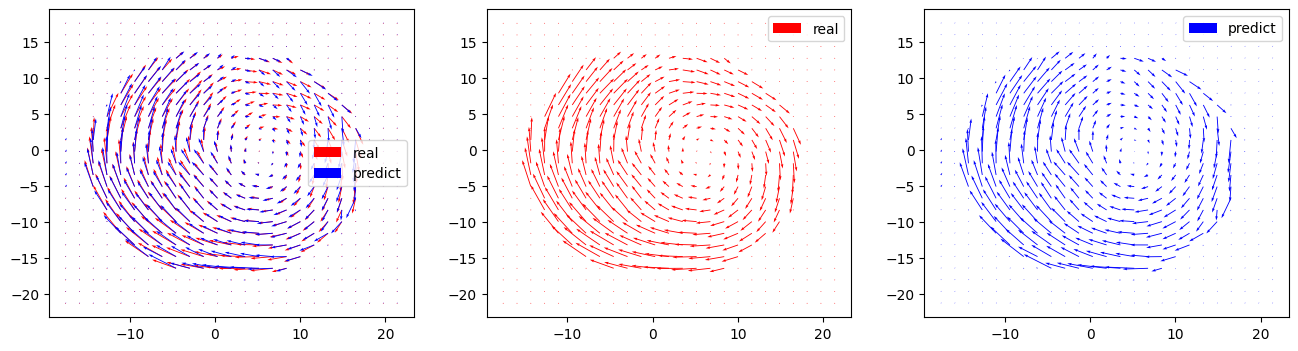

MI(average/percent):
0.9327886179322885 0.9451612903225807
SI(average/percent):
0.9676856853645812 0.964516129032258
56
MI(average/percent):
0.9313127278963211 0.9419354838709677
SI(average/percent):
0.9671613183127187 0.964516129032258
57
MI(average/percent):
0.929042891039347 0.9419354838709677
SI(average/percent):
0.9664648497257441 0.967741935483871
58
MI(average/percent):
0.9260535390687523 0.9354838709677419
SI(average/percent):
0.9655400696333829 0.964516129032258
59
MI(average/percent):
0.9227690424451873 0.9290322580645162
SI(average/percent):
0.9642940069415161 0.9580645161290322
60


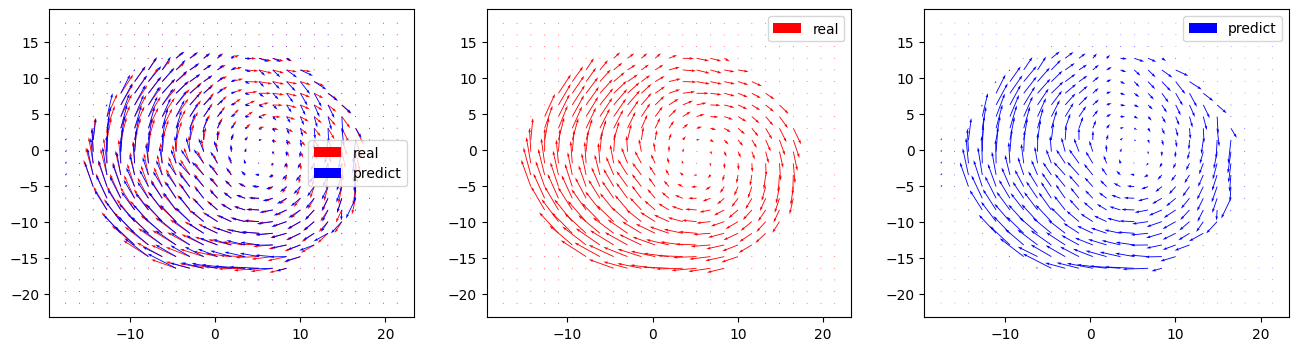

MI(average/percent):
0.9190396898769824 0.9225806451612903
SI(average/percent):
0.9625735658288703 0.9548387096774194
61
MI(average/percent):
0.9200938823901811 0.9290322580645162
SI(average/percent):
0.962483398855652 0.9516129032258065
62
MI(average/percent):
0.9207068868125868 0.9290322580645162
SI(average/percent):
0.9621652823407859 0.9516129032258065
63
MI(average/percent):
0.9209996912304758 0.9225806451612903
SI(average/percent):
0.9616657979759771 0.9548387096774194
64
MI(average/percent):
0.9208586684026433 0.9193548387096774
SI(average/percent):
0.9610531610103386 0.9580645161290322
65


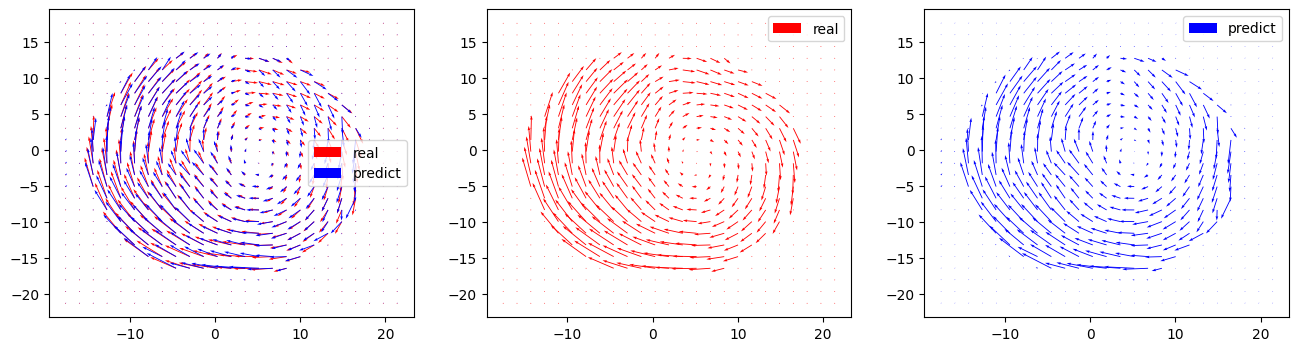

MI(average/percent):
0.920415075461328 0.9225806451612903
SI(average/percent):
0.9603753596002766 0.9612903225806452
66
MI(average/percent):
0.9193966267286127 0.9290322580645162
SI(average/percent):
0.9592995372570996 0.9419354838709677
67
MI(average/percent):
0.917750515169044 0.9387096774193548
SI(average/percent):
0.9579169445000106 0.932258064516129
68
MI(average/percent):
0.9155933365859252 0.9354838709677419
SI(average/percent):
0.9562078777851609 0.9258064516129032
69
MI(average/percent):
0.9130375803517536 0.9258064516129032
SI(average/percent):
0.9541554525574403 0.9129032258064517
70


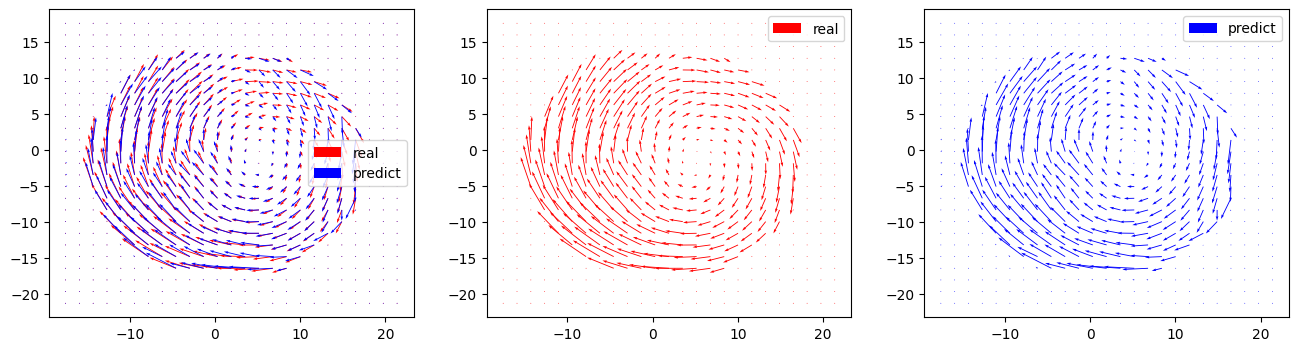

MI(average/percent):
0.9101618679206963 0.9129032258064517
SI(average/percent):
0.9517494647451192 0.9032258064516129
71
MI(average/percent):
0.9097888429265332 0.9161290322580645
SI(average/percent):
0.9525717802313904 0.9032258064516129
72
MI(average/percent):
0.909176213183193 0.9129032258064517
SI(average/percent):
0.9532549593944888 0.9064516129032258
73
MI(average/percent):
0.9081466394717462 0.9064516129032258
SI(average/percent):
0.9538001657930886 0.9096774193548387
74
MI(average/percent):
0.9069949220031004 0.896774193548387
SI(average/percent):
0.9542078864538996 0.9129032258064517
75


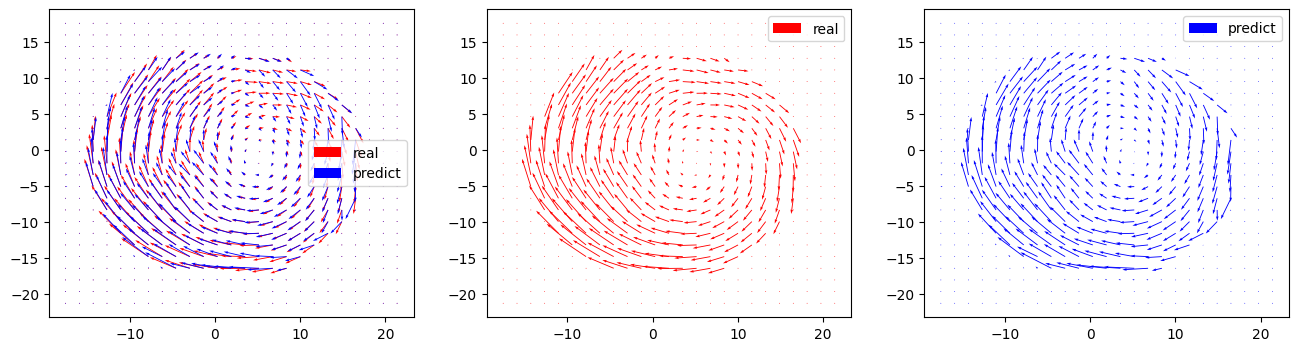

MI(average/percent):
0.9053589109456253 0.8903225806451613
SI(average/percent):
0.9544771485630652 0.9129032258064517
76
MI(average/percent):
0.9067630453457286 0.9
SI(average/percent):
0.9559230515651466 0.9225806451612903
77
MI(average/percent):
0.9076410718728182 0.9064516129032258
SI(average/percent):
0.9572393823063575 0.9258064516129032
78
MI(average/percent):
0.9080995767024432 0.9064516129032258
SI(average/percent):
0.9584502036716452 0.9290322580645162
79
MI(average/percent):
0.9079877850494507 0.9032258064516129
SI(average/percent):
0.959557259055584 0.9419354838709677
80


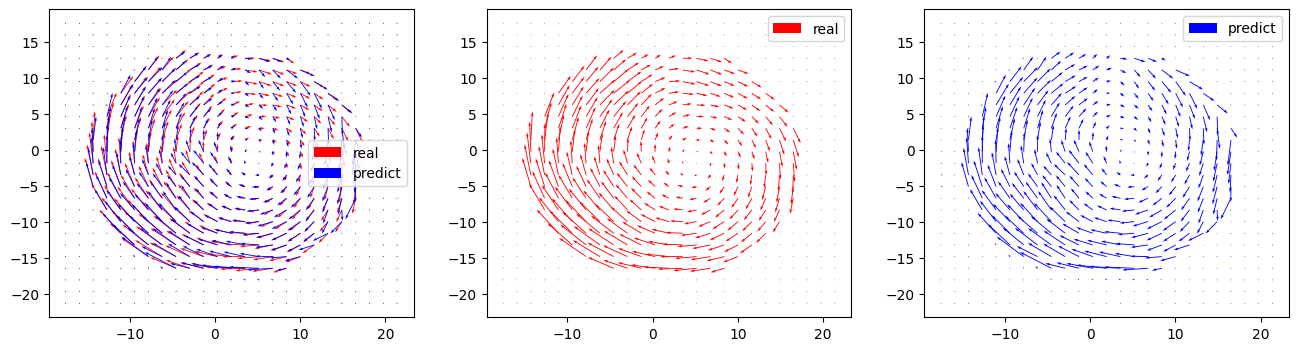

MI(average/percent):
0.9073791150953306 0.8935483870967742
SI(average/percent):
0.9605511001821295 0.9483870967741935
81
MI(average/percent):
0.9072419119335806 0.8838709677419355
SI(average/percent):
0.9602702263390602 0.9451612903225807
82
MI(average/percent):
0.9066806136154688 0.8838709677419355
SI(average/percent):
0.9598506546889883 0.9419354838709677
83
MI(average/percent):
0.9059391824346226 0.8838709677419355
SI(average/percent):
0.9592524444871176 0.9387096774193548
84
MI(average/percent):
0.9049806917343131 0.8870967741935484
SI(average/percent):
0.9584465522339175 0.9354838709677419
85


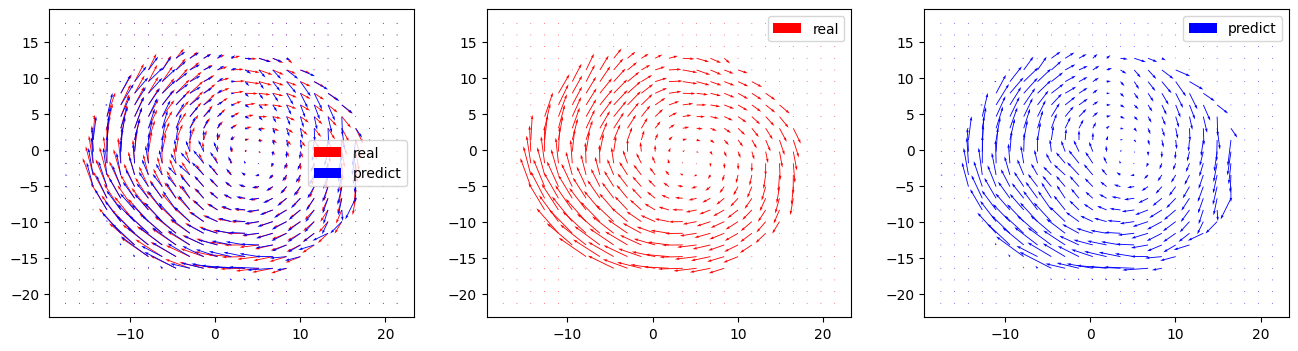

MI(average/percent):
0.9034979066260751 0.8806451612903226
SI(average/percent):
0.9574115559255487 0.9387096774193548
86
MI(average/percent):
0.9050374446944666 0.8774193548387097
SI(average/percent):
0.958452497274324 0.9483870967741935
87
MI(average/percent):
0.9056973582141699 0.8709677419354839
SI(average/percent):
0.9591811229058692 0.9483870967741935
88
MI(average/percent):
0.9061368683281983 0.8709677419354839
SI(average/percent):
0.9595815033943623 0.9419354838709677
89
MI(average/percent):
0.9060825238552467 0.8709677419354839
SI(average/percent):
0.9567013963980961 0.9451612903225807
90


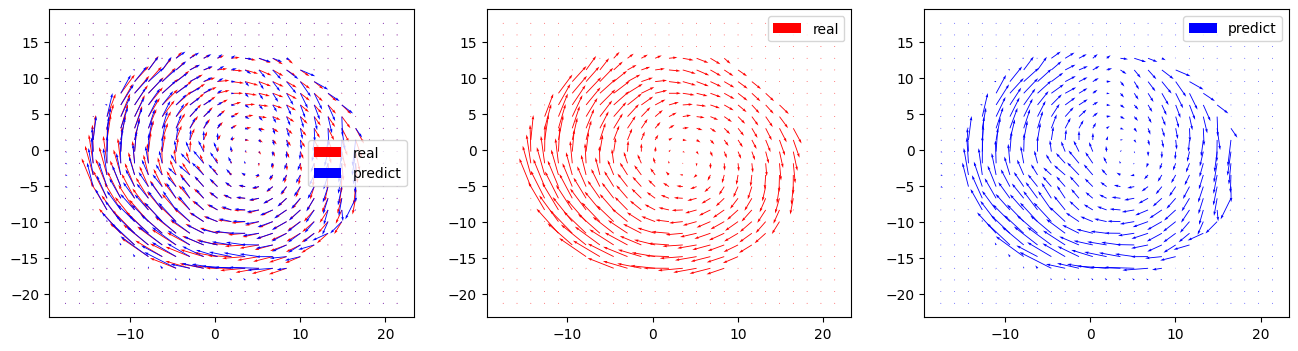

MI(average/percent):
0.9066745519111362 0.867741935483871
SI(average/percent):
0.9590291107627162 0.9516129032258065
91
MI(average/percent):
0.9067062540732559 0.8612903225806452
SI(average/percent):
0.9587076711879728 0.9548387096774194
92
MI(average/percent):
0.9060432873925764 0.864516129032258
SI(average/percent):
0.9581254610960047 0.9548387096774194
93
MI(average/percent):
0.9047543794303172 0.864516129032258
SI(average/percent):
0.9572335138587655 0.9580645161290322
94
MI(average/percent):
0.9031737422006968 0.867741935483871
SI(average/percent):
0.9559639013988886 0.964516129032258
95


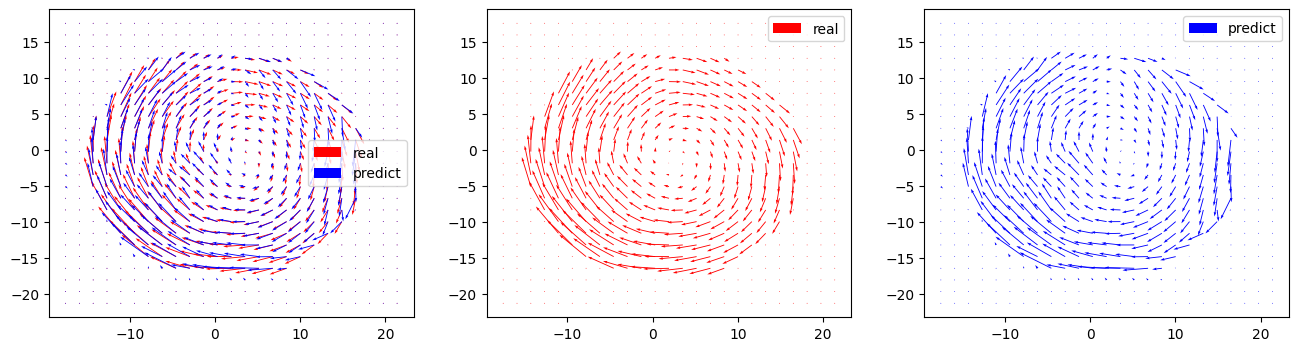

MI(average/percent):
0.9013410828446804 0.8709677419354839
SI(average/percent):
0.9541744314611382 0.9580645161290322
96
MI(average/percent):
0.9020383133370838 0.8709677419354839
SI(average/percent):
0.9524785448549021 0.9548387096774194
97
MI(average/percent):
0.9024036001774086 0.8709677419354839
SI(average/percent):
0.9504442892880928 0.9451612903225807
98
MI(average/percent):
0.9020513146793966 0.8774193548387097
SI(average/percent):
0.9480654598080576 0.9419354838709677
99
MI(average/percent):
0.9014640778979697 0.8774193548387097
SI(average/percent):
0.9456140336760301 0.9354838709677419
100


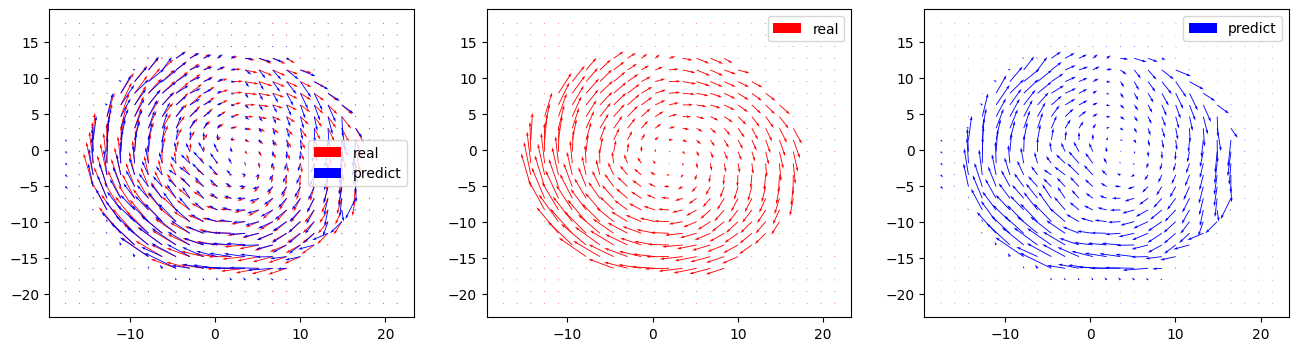

MI(average/percent):
0.9007962690459319 0.8838709677419355
SI(average/percent):
0.9434419524257409 0.9354838709677419
101
MI(average/percent):
0.9008352510528632 0.8806451612903226
SI(average/percent):
0.9441707910209466 0.932258064516129
102
MI(average/percent):
0.9008488889655591 0.8806451612903226
SI(average/percent):
0.9452341479173565 0.9387096774193548
103
MI(average/percent):
0.9005695003816183 0.8806451612903226
SI(average/percent):
0.9454962827847609 0.9354838709677419
104
MI(average/percent):
0.9000241334064091 0.8870967741935484
SI(average/percent):
0.9452383698922431 0.9387096774193548
105


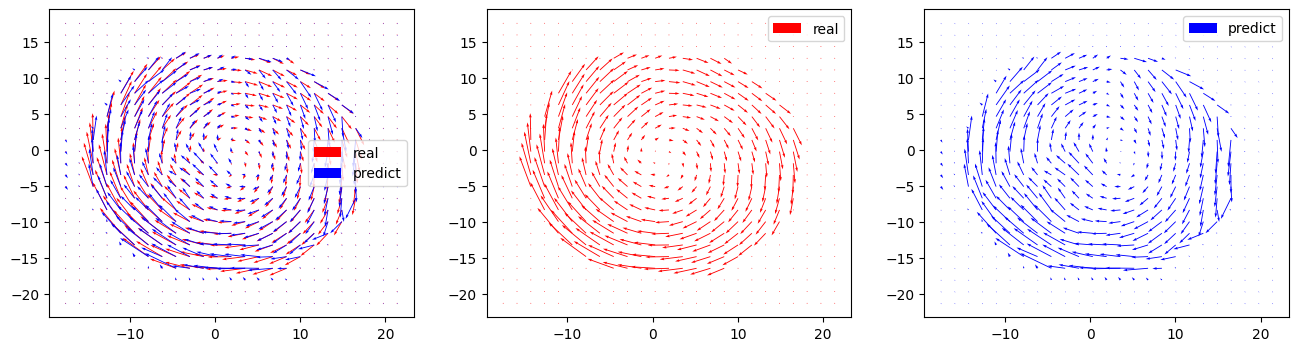

MI(average/percent):
0.8992455273222721 0.8806451612903226
SI(average/percent):
0.9445581055937142 0.9354838709677419
106
MI(average/percent):
0.8980021497725337 0.8741935483870967
SI(average/percent):
0.9433170867265638 0.932258064516129
107
MI(average/percent):
0.8964615472985135 0.867741935483871
SI(average/percent):
0.9416882530232926 0.932258064516129
108
MI(average/percent):
0.8948694688799996 0.864516129032258
SI(average/percent):
0.9396323978119011 0.932258064516129
109
MI(average/percent):
0.8931889940491254 0.8548387096774194
SI(average/percent):
0.9380010972964616 0.9258064516129032
110


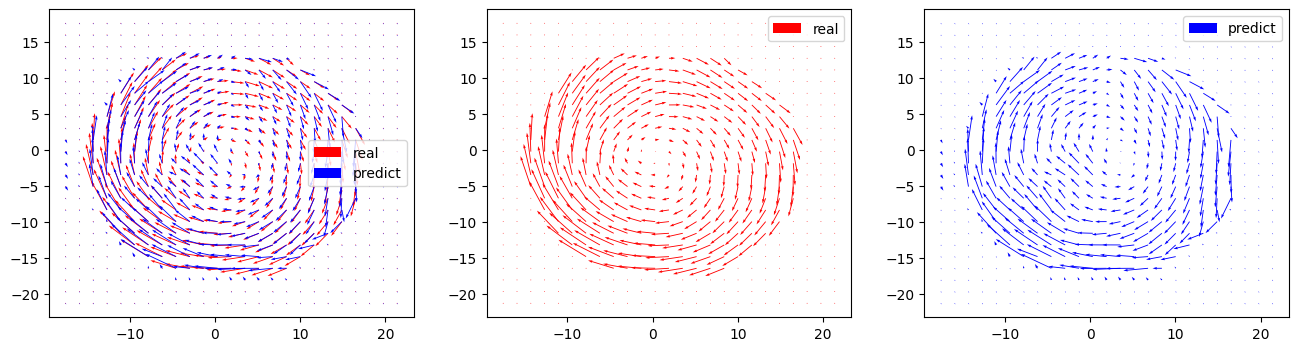

MI(average/percent):
0.8914268688641348 0.8516129032258064
SI(average/percent):
0.937183760055743 0.932258064516129
111
MI(average/percent):
0.8919109634436104 0.8483870967741935
SI(average/percent):
0.9361985403987301 0.9225806451612903
112
MI(average/percent):
0.8921288754656919 0.8548387096774194
SI(average/percent):
0.9345626488922504 0.9225806451612903
113
MI(average/percent):
0.8918881912594161 0.8451612903225807
SI(average/percent):
0.9329014014241153 0.9225806451612903
114
MI(average/percent):
0.8915069989799145 0.8548387096774194
SI(average/percent):
0.9316863465901378 0.932258064516129
115


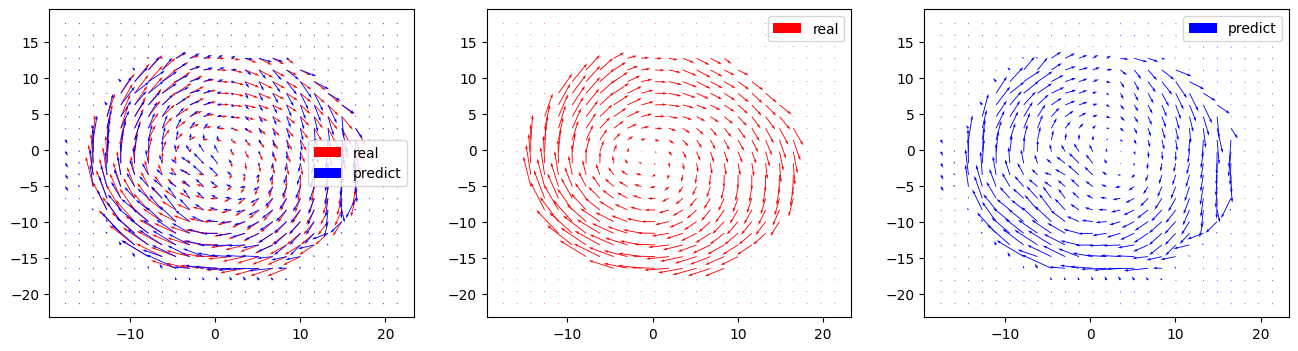

MI(average/percent):
0.8911136212831513 0.8516129032258064
SI(average/percent):
0.930296499457539 0.9354838709677419
116
MI(average/percent):
0.8908151513399531 0.8516129032258064
SI(average/percent):
0.9272886747812028 0.9225806451612903
117
MI(average/percent):
0.8903494473137173 0.8516129032258064
SI(average/percent):
0.9263678888932139 0.9064516129032258
118
MI(average/percent):
0.8890409340567224 0.8516129032258064
SI(average/percent):
0.9234834649259726 0.9064516129032258
119
MI(average/percent):
0.8875058989707623 0.8483870967741935
SI(average/percent):
0.92053195009794 0.9
120


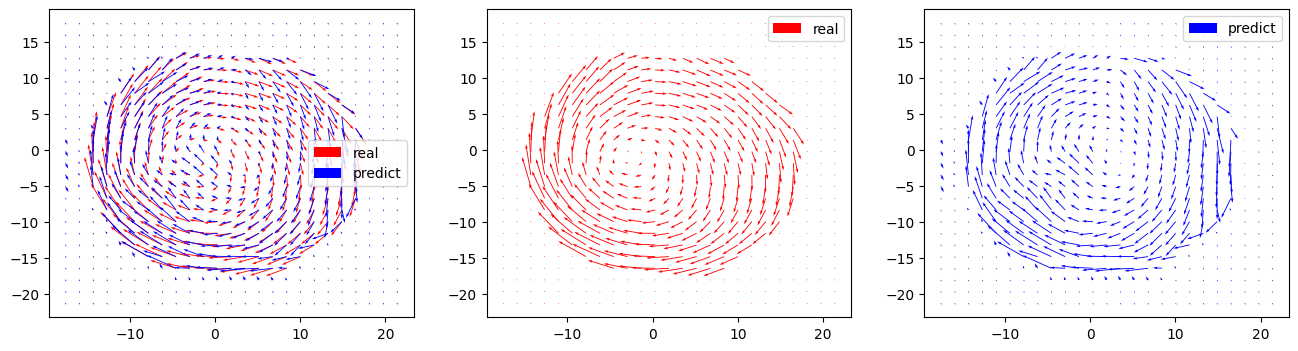

MI(average/percent):
0.8859571600742808 0.8516129032258064
SI(average/percent):
0.9168783416653558 0.8903225806451613
121
MI(average/percent):
0.8848866532123669 0.8419354838709677
SI(average/percent):
0.9168176322641564 0.8935483870967742
122
MI(average/percent):
0.8836422775370181 0.8419354838709677
SI(average/percent):
0.9174527618527555 0.9
123
MI(average/percent):
0.8823271167623344 0.8387096774193549
SI(average/percent):
0.9178946501684627 0.9
124
MI(average/percent):
0.880831594372442 0.832258064516129
SI(average/percent):
0.9176298874550864 0.9
125


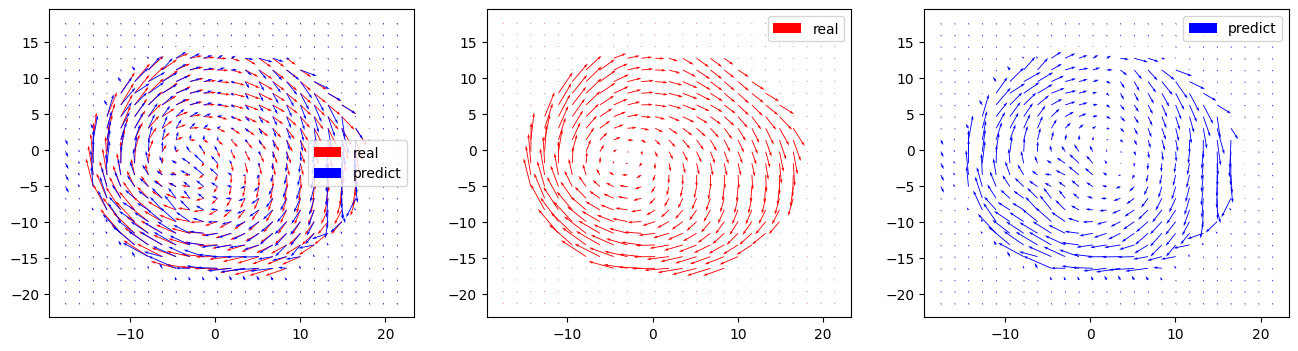

MI(average/percent):
0.8789731680481123 0.8290322580645161
SI(average/percent):
0.9168103592770604 0.9
126
MI(average/percent):
0.878368623729588 0.8290322580645161
SI(average/percent):
0.9163451410058641 0.896774193548387
127
MI(average/percent):
0.8773873428081868 0.8193548387096774
SI(average/percent):
0.915399668396719 0.896774193548387
128
MI(average/percent):
0.8762945653471068 0.8290322580645161
SI(average/percent):
0.9142707774967223 0.8935483870967742
129
MI(average/percent):
0.8751317991176768 0.8258064516129032
SI(average/percent):
0.9133553082952062 0.8903225806451613
130


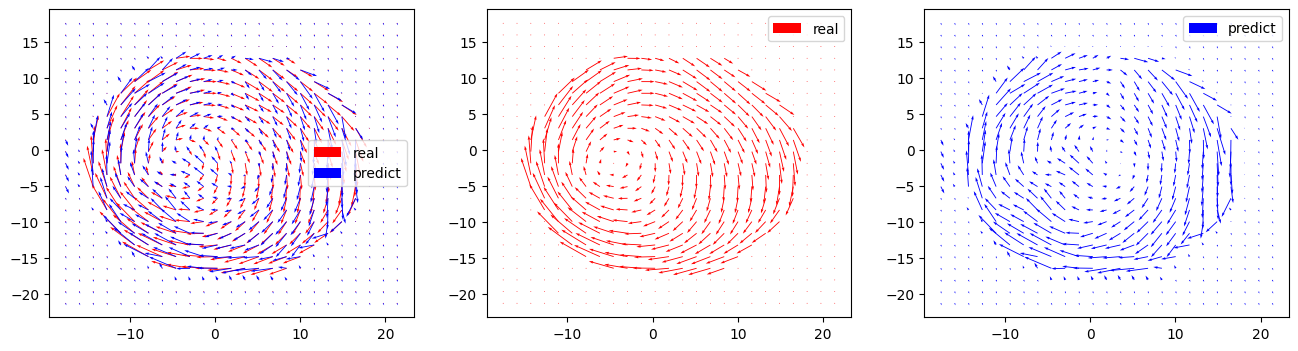

MI(average/percent):
0.8741930884684795 0.8258064516129032
SI(average/percent):
0.9119762275445418 0.8806451612903226
131
MI(average/percent):
0.8729481036588286 0.8193548387096774
SI(average/percent):
0.9090483864661868 0.8774193548387097
132
MI(average/percent):
0.8713418650481001 0.8161290322580645
SI(average/percent):
0.9083701966265614 0.8741935483870967
133
MI(average/percent):
0.8696476088197937 0.8
SI(average/percent):
0.9068919771460677 0.867741935483871
134
MI(average/percent):
0.867770463286399 0.7870967741935484
SI(average/percent):
0.9049126040553659 0.864516129032258
135


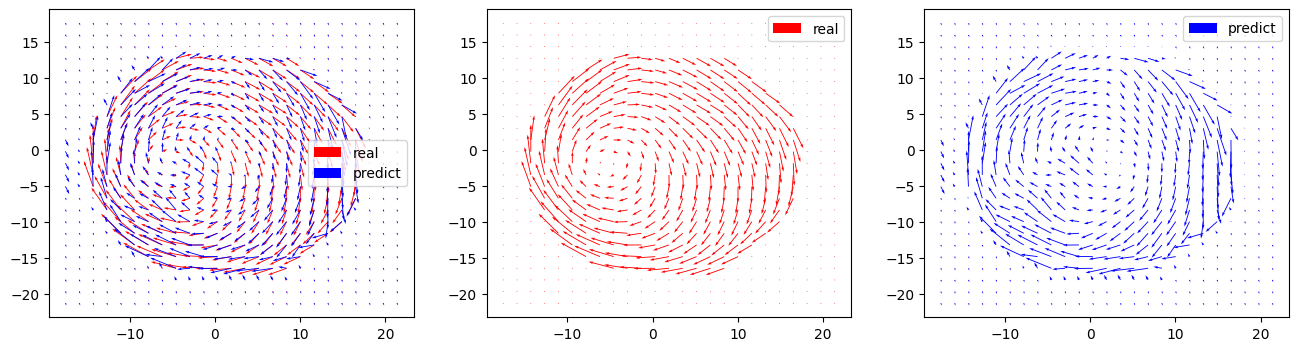

MI(average/percent):
0.8654641505105957 0.7870967741935484
SI(average/percent):
0.9024940938558668 0.8612903225806452
136
MI(average/percent):
0.8646996434747366 0.7838709677419354
SI(average/percent):
0.9003425018582955 0.8612903225806452
137
MI(average/percent):
0.8639757030205846 0.7903225806451613
SI(average/percent):
0.8977933945687195 0.8580645161290322
138
MI(average/percent):
0.8629825663556407 0.7903225806451613
SI(average/percent):
0.8962945241602625 0.8483870967741935
139
MI(average/percent):
0.8620021711178883 0.7935483870967742
SI(average/percent):
0.8938926920892031 0.8483870967741935
140


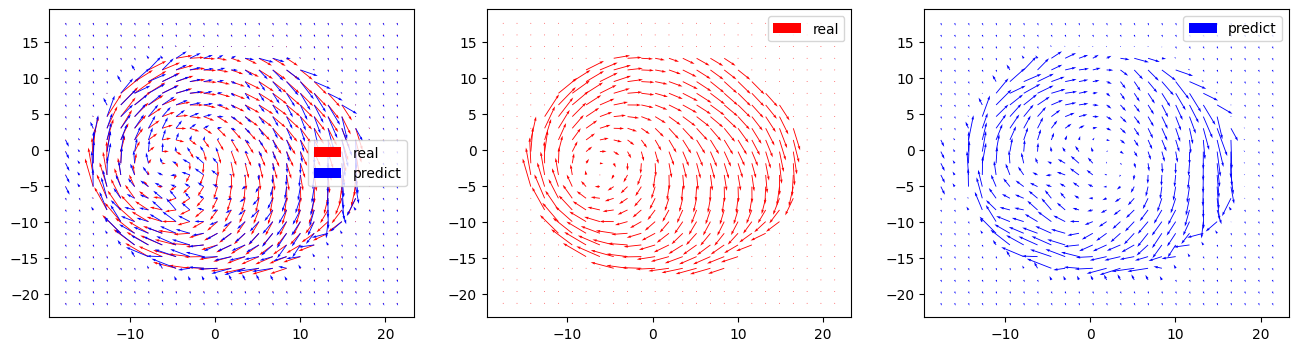

MI(average/percent):
0.8608502048655127 0.7935483870967742
SI(average/percent):
0.8899110363976198 0.8451612903225807
141
MI(average/percent):
0.8591381123557523 0.7741935483870968
SI(average/percent):
0.8883612412862025 0.8483870967741935
142
MI(average/percent):
0.8570127030663172 0.7741935483870968
SI(average/percent):
0.8883276218336275 0.8483870967741935
143
MI(average/percent):
0.854526340964494 0.7709677419354839
SI(average/percent):
0.8878425563568707 0.8419354838709677
144
MI(average/percent):
0.8518237328858722 0.7580645161290323
SI(average/percent):
0.8872213688144177 0.8419354838709677
145


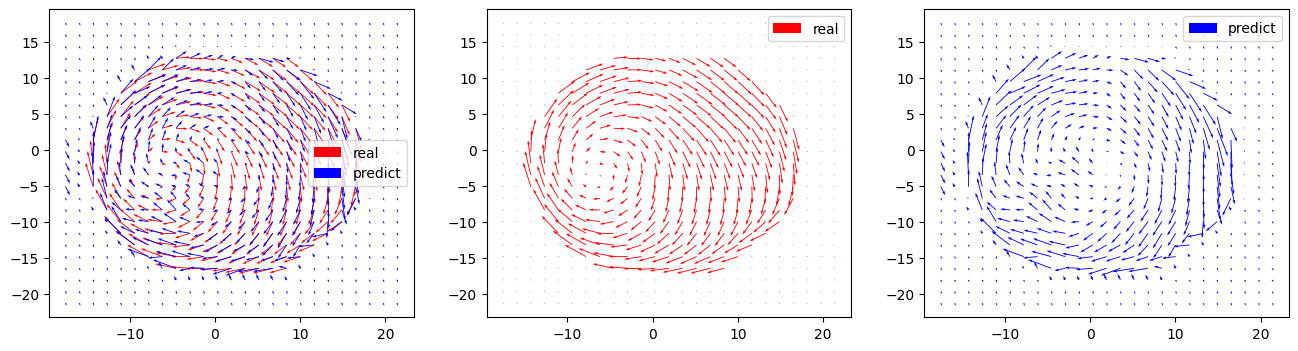

MI(average/percent):
0.8487251934454917 0.7451612903225806
SI(average/percent):
0.8862524837331539 0.8387096774193549
146
MI(average/percent):
0.8467761630446478 0.7419354838709677
SI(average/percent):
0.8840454311492824 0.8387096774193549
147
MI(average/percent):
0.8441968319579943 0.7354838709677419
SI(average/percent):
0.8815822091660801 0.8354838709677419
148
MI(average/percent):
0.8414489821400747 0.7290322580645161
SI(average/percent):
0.8789324194133066 0.8387096774193549
149
MI(average/percent):
0.8387753498671596 0.7258064516129032
SI(average/percent):
0.876400585781687 0.832258064516129
150


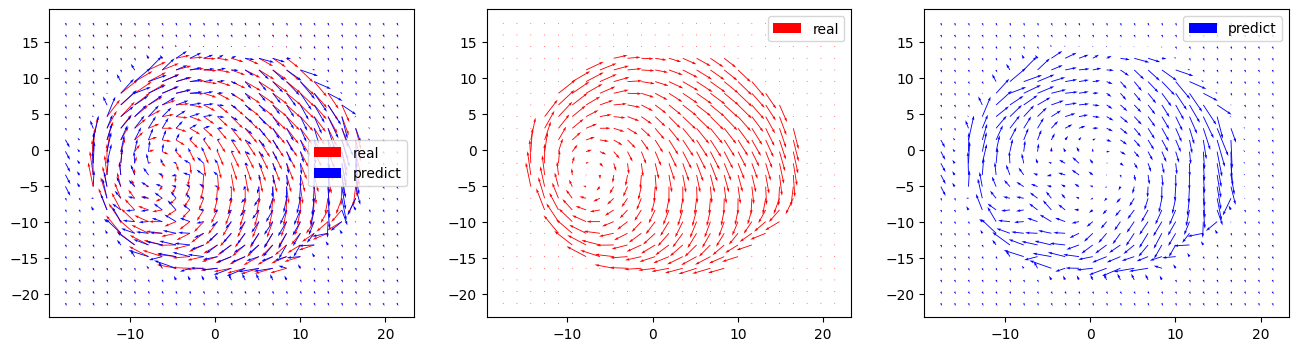

MI(average/percent):
0.8361632276983273 0.7193548387096774
SI(average/percent):
0.8745674822197489 0.8225806451612904
151
MI(average/percent):
0.8351260351808211 0.7193548387096774
SI(average/percent):
0.8764111953814844 0.8225806451612904
152
MI(average/percent):
0.8342774680772411 0.7193548387096774
SI(average/percent):
0.8762585348063306 0.8258064516129032
153
MI(average/percent):
0.8332647858566462 0.7193548387096774
SI(average/percent):
0.8753472912539703 0.8290322580645161
154
MI(average/percent):
0.8320825911622787 0.7161290322580646
SI(average/percent):
0.8745136424998524 0.8290322580645161
155


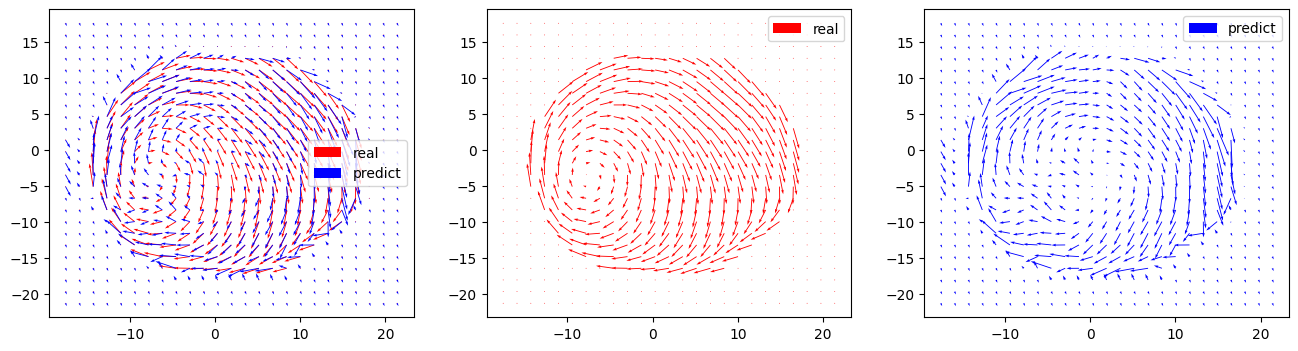

MI(average/percent):
0.8307087077299796 0.7161290322580646
SI(average/percent):
0.8736242712473816 0.8193548387096774
156
MI(average/percent):
0.8303151404046011 0.7161290322580646
SI(average/percent):
0.8732451324576754 0.8161290322580645
157
MI(average/percent):
0.8300070146922908 0.7193548387096774
SI(average/percent):
0.8737619649098058 0.8225806451612904
158
MI(average/percent):
0.8297981685393754 0.7161290322580646
SI(average/percent):
0.8735654656305224 0.8096774193548387
159
MI(average/percent):
0.8296234471073529 0.7096774193548387
SI(average/percent):
0.8732687687209457 0.8
160


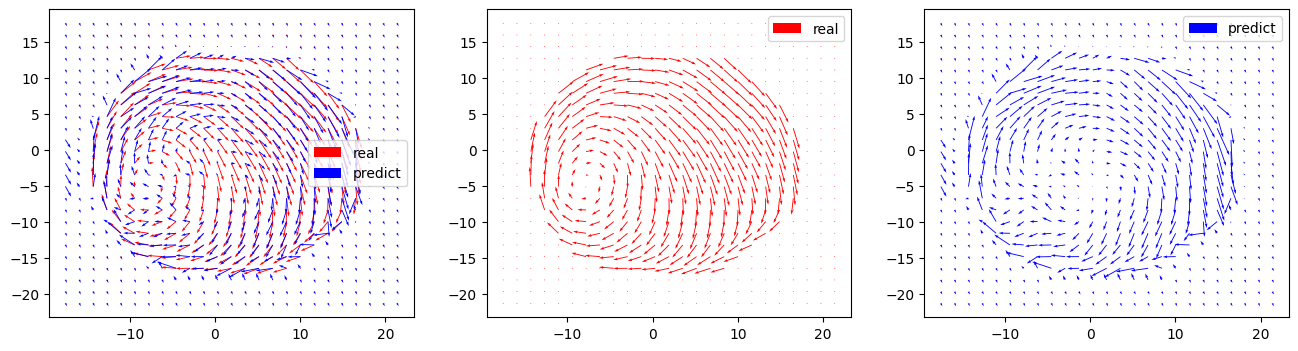

MI(average/percent):
0.8292971716047971 0.7032258064516129
SI(average/percent):
0.8726662680557894 0.7967741935483871
161
MI(average/percent):
0.8285189694705504 0.7
SI(average/percent):
0.8737302891770482 0.7967741935483871
162
MI(average/percent):
0.8273788052217993 0.6967741935483871
SI(average/percent):
0.8755834475064254 0.8
163
MI(average/percent):
0.8261320868565646 0.7
SI(average/percent):
0.877546620196597 0.8032258064516129
164
MI(average/percent):
0.8248053541249913 0.7064516129032258
SI(average/percent):
0.8788708305845373 0.8064516129032258
165


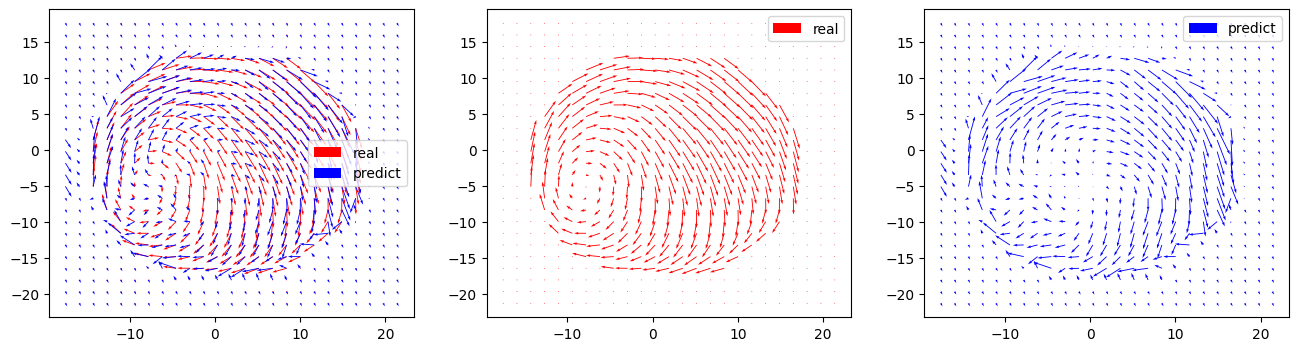

MI(average/percent):
0.8233118265687334 0.7032258064516129
SI(average/percent):
0.879696658663977 0.8064516129032258
166
MI(average/percent):
0.8243577746880675 0.7064516129032258
SI(average/percent):
0.880970447954946 0.8161290322580645
167
MI(average/percent):
0.825482064384521 0.7129032258064516
SI(average/percent):
0.880845307575806 0.8129032258064516
168
MI(average/percent):
0.826588256036246 0.7193548387096774
SI(average/percent):
0.8801184042098998 0.8258064516129032
169
MI(average/percent):
0.8272712409119967 0.7129032258064516
SI(average/percent):
0.8793199321637419 0.8161290322580645
170


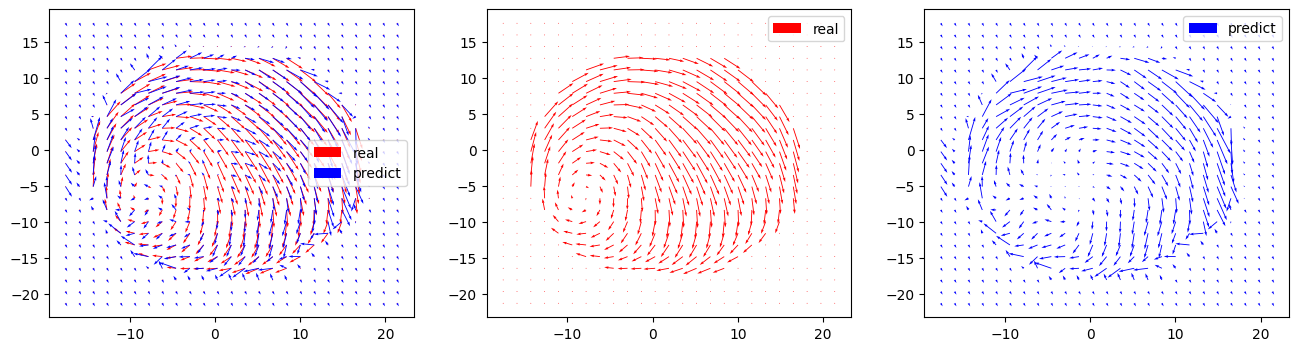

MI(average/percent):
0.8278720736160157 0.7096774193548387
SI(average/percent):
0.878586323782851 0.8096774193548387
171
MI(average/percent):
0.827901604332343 0.7096774193548387
SI(average/percent):
0.8776206894172605 0.8161290322580645
172
MI(average/percent):
0.8279098080097864 0.7161290322580646
SI(average/percent):
0.8761668522552355 0.8129032258064516
173
MI(average/percent):
0.827933476730034 0.7129032258064516
SI(average/percent):
0.8745066515934544 0.8096774193548387
174
MI(average/percent):
0.8277671246364752 0.7161290322580646
SI(average/percent):
0.8752355712839809 0.8096774193548387
175


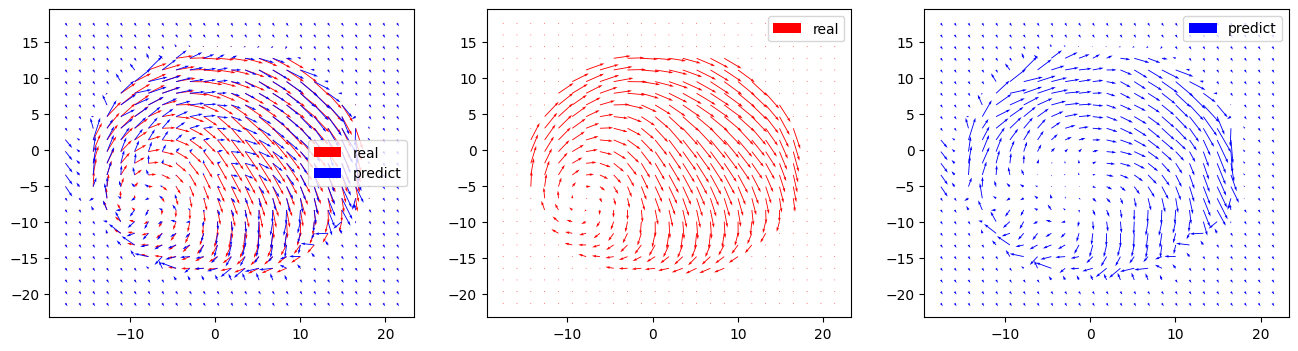

MI(average/percent):
0.8275495456232557 0.7225806451612903
SI(average/percent):
0.8767855519023546 0.8129032258064516
176
MI(average/percent):
0.8272415319032728 0.7161290322580646
SI(average/percent):
0.8796657154437297 0.8161290322580645
177
MI(average/percent):
0.8261865833804608 0.7064516129032258
SI(average/percent):
0.881014272903439 0.8129032258064516
178
MI(average/percent):
0.8249646533088633 0.7096774193548387
SI(average/percent):
0.8809667073888067 0.8129032258064516
179
MI(average/percent):
0.8235750732905147 0.6967741935483871
SI(average/percent):
0.8827328021824606 0.8096774193548387
180


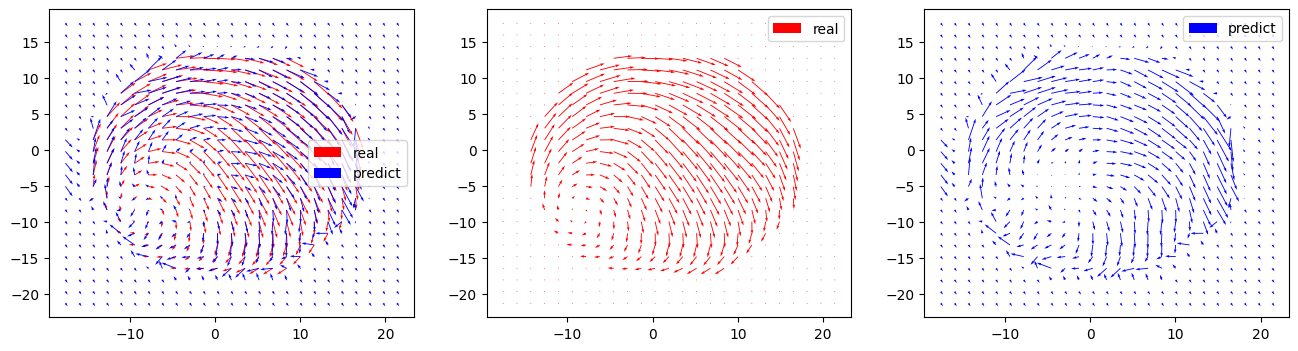

MI(average/percent):
0.8221012678115963 0.6967741935483871
SI(average/percent):
0.8831773565038932 0.8129032258064516
181
MI(average/percent):
0.8222958710140649 0.6903225806451613
SI(average/percent):
0.88339568335334 0.8193548387096774
182
MI(average/percent):
0.8223911014807319 0.6903225806451613
SI(average/percent):
0.8828894621227339 0.8129032258064516
183
MI(average/percent):
0.8225559157035394 0.6870967741935484
SI(average/percent):
0.8822181637614581 0.8129032258064516
184
MI(average/percent):
0.8227532243294735 0.6741935483870968
SI(average/percent):
0.8811820584542169 0.8096774193548387
185


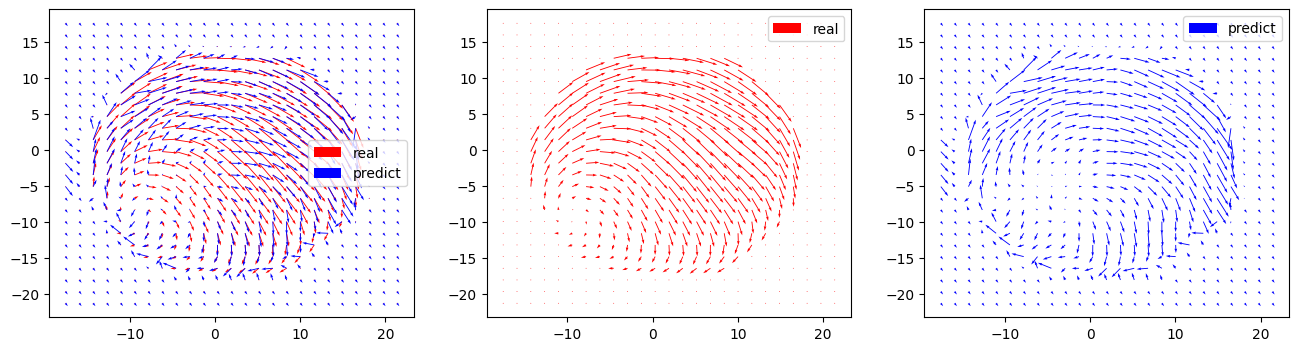

MI(average/percent):
0.8229521035434446 0.6709677419354839
SI(average/percent):
0.8792976306698403 0.8096774193548387
186
MI(average/percent):
0.822188241183331 0.6741935483870968
SI(average/percent):
0.877982260431546 0.8096774193548387
187
MI(average/percent):
0.8210661481700188 0.667741935483871
SI(average/percent):
0.8761243809824477 0.8032258064516129
188
MI(average/percent):
0.8198951199483033 0.667741935483871
SI(average/percent):
0.8737392446829628 0.7967741935483871
189
MI(average/percent):
0.8188595075792974 0.6709677419354839
SI(average/percent):
0.870649123852457 0.7935483870967742
190


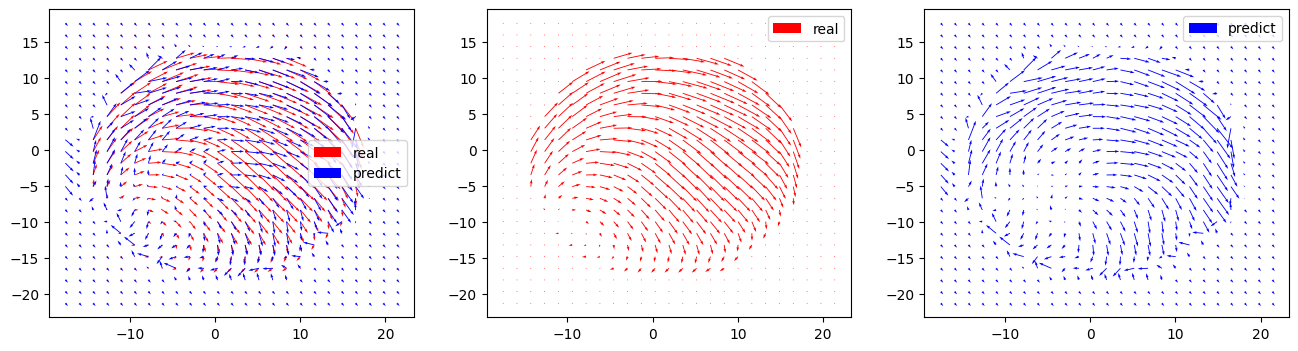

MI(average/percent):
0.8179225245270265 0.6870967741935484
SI(average/percent):
0.8686925609567714 0.7935483870967742
191
MI(average/percent):
0.8169198276367696 0.6806451612903226
SI(average/percent):
0.865735558249828 0.7935483870967742
192
MI(average/percent):
0.8161109648672263 0.6838709677419355
SI(average/percent):
0.8612047863129887 0.7774193548387097
193
MI(average/percent):
0.8154510026145069 0.6806451612903226
SI(average/percent):
0.8550863249474254 0.7806451612903226
194
MI(average/percent):
0.815168594615034 0.6741935483870968
SI(average/percent):
0.8490119064362086 0.7709677419354839
195


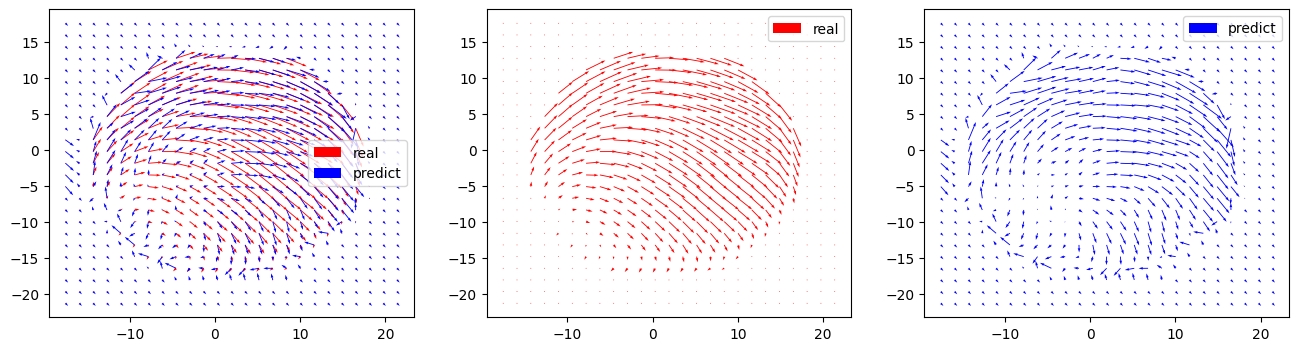

MI(average/percent):
0.8152660186046067 0.667741935483871
SI(average/percent):
0.8436547242288819 0.7709677419354839


In [13]:
count=0
for i in range(p_tot):
    print(i/addp)
    j=i
    if i%(addp)==0:
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 3, 1)
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
        plt.legend()
        plt.subplot(1, 3, 2)
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
        plt.legend()
        plt.subplot(1, 3, 3)
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
        plt.legend()
        plt.show()
    mi_t[i],mi_t_per[i]=miscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    si_t[i],si_t_per[i]=siscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    if i%(addp)==0 and mi_t_per[i]>0.85 and si_t_per[i]>0.85:
        count+=1

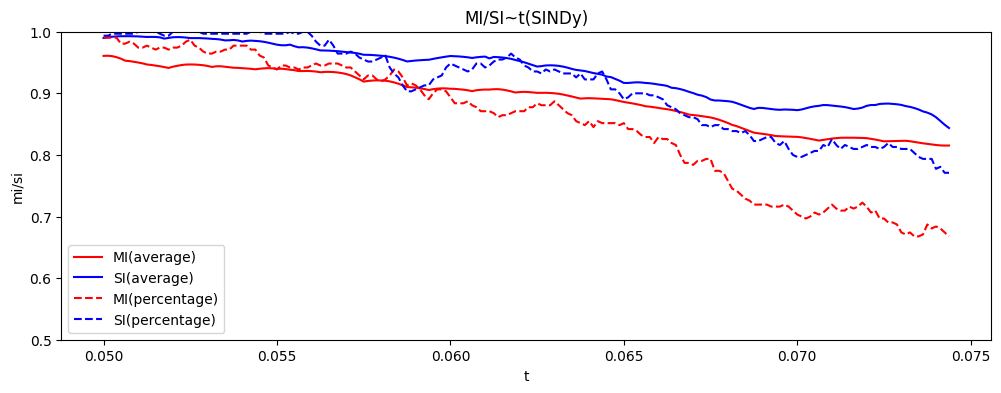

In [14]:
plt.figure(figsize=(12, 4))
plt.title('MI/SI~t(SINDy)')
plt.ylim(0,1)
plt.xlabel('t')
plt.ylabel('mi/si')
plt.plot(t_train,mi_t,'r',label='MI(average)')
plt.plot(t_train,si_t,'b',label='SI(average)')
plt.plot(t_train,mi_t_per,'r--',label='MI(percentage)')
plt.plot(t_train,si_t_per,'b--',label='SI(percentage)')
plt.legend()
plt.ylim(0.5, 1)
plt.show()